Primero:
    
    1.Obtner mejores datos y no guardar noralizados
    2.HAcer por bloques de rating no con tanto detalle de rating
    3.Hacer con sus spead como Y en lugar del rating (sacar bonos a 10Y pasar a monda del rf y restar la yield del rf)
    
Problemas:

    1.tenemos mayoria entorno a BBB el modelo se va siempre a ese entorno
    7 ojo porque estoy pillando tambien gobiernos
Pendientes:
    
    1.una vez tengamos los datos, desnormalizarlos para poder usar los ratios directamente
    5.Explicar todo el código bien.
    6.para el problema de tener pocos datos de una clase, undersampling o oversampling o decir a kaeras que no estan balanciados
    8.meter las betas de las compañias, mayor beta mayor riesgo
    9.elgir las mejores variables que lo expliquen
    10.Ver si con Eikon se puede obetner algo mejor
    10 over y under sampling https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

# Estudio de ratings

El objetivo de este trabajo es obtener un rating para una compañia, a partir de sus principales ratios de solvencia.

Importamos los modulos necesarios:

In [1]:
import pandas as pd
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.datasets import make_classification
from scipy.stats import pearsonr, ttest_ind
import cufflinks as cf
from functions import *

plt.style.use('ggplot')

Importamos los datos de QIC y dejamos una base de datos limpia, esto se hacen en este [notebook](./Carga_Datos.ipynb). En caso de tener ya los datos no es necesario hacer todo esto y podermos pasar directamente a leer los datos [aqui](#another_cell).

## Lectura de datos <a id='another_cell'></a>

In [30]:
df = pd.read_csv("Clean_Data.csv", index_col=0)
[print(c," "*(30-len(c)),'Número de variables diferentes:',len(set(df[c]))) for c in df.columns]
df.head()

ID                              Número de variables diferentes: 16485
Rating                          Número de variables diferentes: 21
Sector                          Número de variables diferentes: 12
EBITDA / Gastos financieros     Número de variables diferentes: 16398
DFN / EBITDA                    Número de variables diferentes: 16424
Deuda / (Deuda + Equity)        Número de variables diferentes: 16390
Current Ratio                   Número de variables diferentes: 16414
Quick Ratio                     Número de variables diferentes: 16402
Cash Ratio                      Número de variables diferentes: 16161
LT Debt-to-equity               Número de variables diferentes: 16083
Total Debt-to-Equity            Número de variables diferentes: 16390
Debt Ratio                      Número de variables diferentes: 16362
Financial Leverage              Número de variables diferentes: 16390


,ID,Rating,Sector,EBITDA / Gastos financieros,DFN / EBITDA,Deuda / (Deuda + Equity),Current Ratio,Quick Ratio,Cash Ratio,LT Debt-to-equity,Total Debt-to-Equity,Debt Ratio,Financial Leverage
5398,2018-IQ4149300,BBB,Industrials,0.901067,0.130040,0.174707,0.000078,0.001747,0.000757,0.879528,0.388655,2.232909e-06,0.395855
10000,2018-IQ5522615,AAA,Industrials,0.900971,0.130018,0.175714,0.000057,0.001788,0.001113,0.879585,0.388988,1.221880e-06,0.396376
10002,2018-IQ32857171,AAA,Industrials,0.900923,0.128276,0.174319,0.000142,0.003045,0.003186,0.879537,0.388582,4.777209e-06,0.395992
10008,2018-IQ4112645,AAA,Industrials,0.900942,0.130154,0.177266,0.000206,0.009582,0.001618,0.880074,0.393173,5.966204e-07,0.401664
10016,2018-IQ5490337,AAA,Industrials,0.901139,0.129951,0.171633,0.000339,0.005565,0.004911,0.879508,0.388332,5.583994e-06,0.393576


### Observaciones:

Variables X, independientes: 
    
    1.Ratios->Variables númericas, todos los ratios. Luego se verá si existe colinialidad entre ellas y con cuales nos quedamos.
    2.Sector->Variables categoricas (también llamadas variables nominales), tiene dos o más categorías pero no tienen un orden intrínsico en las categorías.
    
Variable Y, dependiente:
    
    1.Rating->Ordinal, no son numéricas pero tienen un orden.

Veamos cuanto valores tenemos por cada variable dependiente, categórica, ratings. Ya que si tenemos muchos ratings de BBB por ejemplo, nuestro modelo estará sesgado.

*Ordinal data can be encoded one of three ways, broadly speaking, but I think it’s safe to say that its encoding is often not carefully considered.*

*1.It can be assumed to be close enough to interval data — with relatively equal magnitudes between the values — to treat it as such. Social scientists make this assumption all the time with Likert scales. For example, “On a scale from 1 to 7, 1 being extremely unlikely, 4 being neither likely nor unlikely and 7 being extremely likely, how likely are you to recommend this movie to a friend?”. Here the difference between 3 and 4 and the difference between 6 and 7 can be reasonably assumed to be similar.*

*2.It can be treated as nominal data, where each category has no numeric relationship to another. One-hot encoding and other encodings appropriate for nominal data make sense here.*

*3.The magnitude of the difference between the numbers can be ignored. You can just train your model with different encodings and seeing which encoding works best.*

Número de datos:  16485


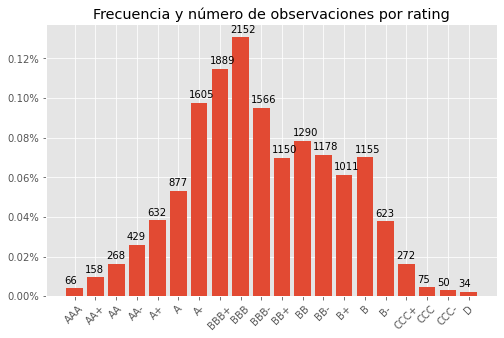

In [27]:
#Ordenamos por rating los datos
All_rating_order = ['AAA+','AAA','AAA-','AA+','AA','AA-','A+','A','A-','BBB+','BBB','BBB-','BB+','BB','BB-','B+','B',
                   'B-','CCC+','CCC','CCC-','C+','C','C-','D']

bar_grafica('Frecuencia y número de observaciones por rating',
            All_rating_order,
            df)

Número de datos:  16485


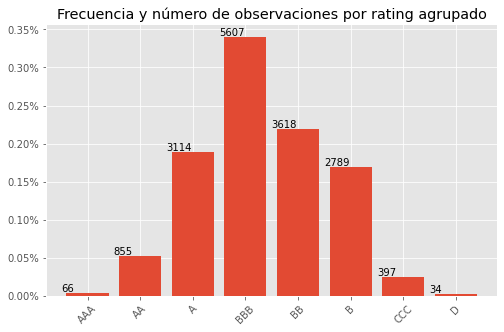

In [26]:
All_rating_order_group = {'AAA+':'AAA','AAA':'AAA','AAA-':'AAA',
                    'AA+':'AA','AA':'AA','AA-':'AA','A+':'A','A':'A','A-':'A',
                    'BBB+':'BBB','BBB':'BBB','BBB-':'BBB','BB+':'BB','BB':'BB','BB-':'BB','B+':'B','B':'B','B-':'B',
                    'CCC+':'CCC','CCC':'CCC','CCC-':'CCC','C+':'C','C':'C','C-':'C','D':'D'}

df_rating_grop = pd.DataFrame(df, copy=True)
df_rating_grop['Rating'].replace(All_rating_order_group, inplace=True) 
bar_grafica('Frecuencia y número de observaciones por rating agrupado',
            All_rating_order_group,
            df_rating_grop)

Este desequilibrio en los datos provoca que el modelo simpre predice entorno a `BBB` por tanto tenemos que multiplicar los datos las otras categorias para poder tener un base de datos mas equilibrada.

Duplicaciones: AAA 32
Duplicaciones: AA+ 13
Duplicaciones: AA 8
Duplicaciones: AA- 5
Duplicaciones: A+ 3
Duplicaciones: A 2
Duplicaciones: BB+ 1
Duplicaciones: BB 1
Duplicaciones: BB- 1
Duplicaciones: B+ 2
Duplicaciones: B 1
Duplicaciones: B- 3
Duplicaciones: CCC+ 7
Duplicaciones: CCC 28
Duplicaciones: CCC- 43
Duplicaciones: D 63
Número de datos:  45550


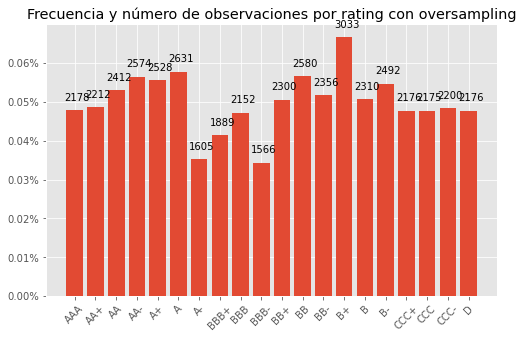

In [56]:
df_duplicados = pd.DataFrame(df, copy=True)
All_rating_increase_dict = {k:0 for k in All_rating_order}

for rating in All_rating_order:
    All_rating_increase_dict[rating] = len(df_duplicados[df_duplicados.Rating == rating])

max_rating = max(All_rating_increase_dict.values())

for rating, v in All_rating_increase_dict.items():
    if v != 0 and v < 1300:
        numero_de_repeticiones = int(max_rating / v ) 
        All_rating_increase_dict[rating] = numero_de_repeticiones
        print("Duplicaciones:",rating,numero_de_repeticiones)
        for i in range(0,numero_de_repeticiones):
            df_duplicados = pd.concat([df_duplicados,df[df.Rating == rating]])

bar_grafica('Frecuencia y número de observaciones por rating con oversampling',
            All_rating_order,
            df_duplicados)

En caso de querer trabajar con los datos dupliocamos ejecutamos el codigo siguiente:

In [ ]:
df = df_duplicados

## Estudio de los datos

Ahora vemos la distribución de nuestro datos. Pero antes un pequeño estudio de como vamos perdiendo datos a medida de que quitamos los extremos.

In [21]:
for percetile in [0,0.1,0.2]:
    df_mod = clean_df(df,df.columns,percetile)
    print([len(set(df_mod[c])) for c in df_mod.columns])

[16475, 21, 12, 16388, 16414, 16380, 16404, 16392, 16151, 16074, 16380, 16352, 16380]
[5744, 20, 11, 5707, 5710, 5699, 5715, 5707, 5561, 5662, 5699, 5689, 5697]
[1768, 19, 11, 1758, 1757, 1759, 1764, 1760, 1689, 1753, 1759, 1754, 1759]


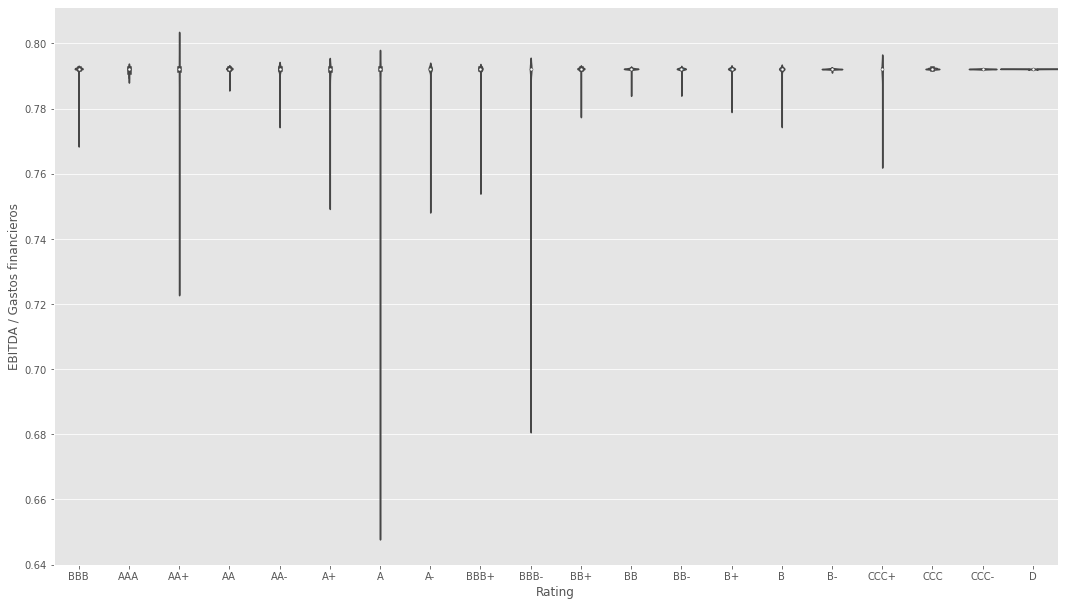

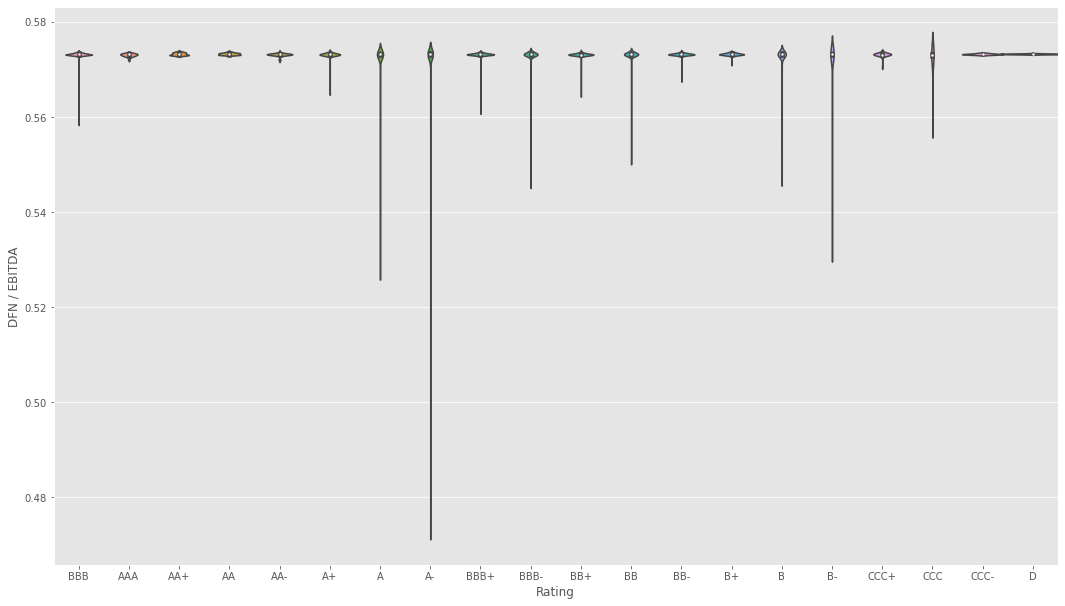

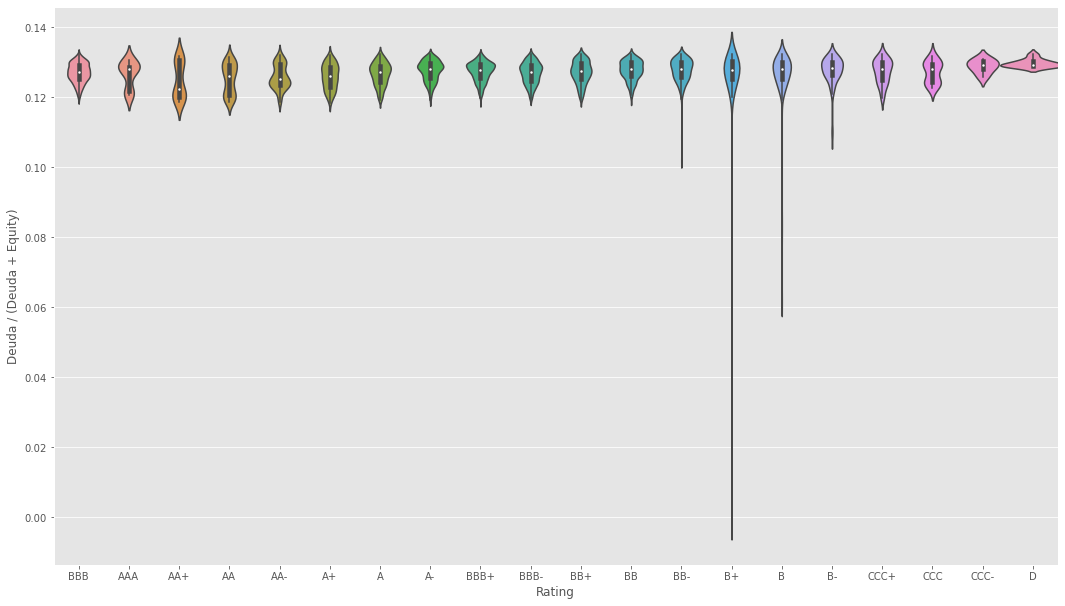

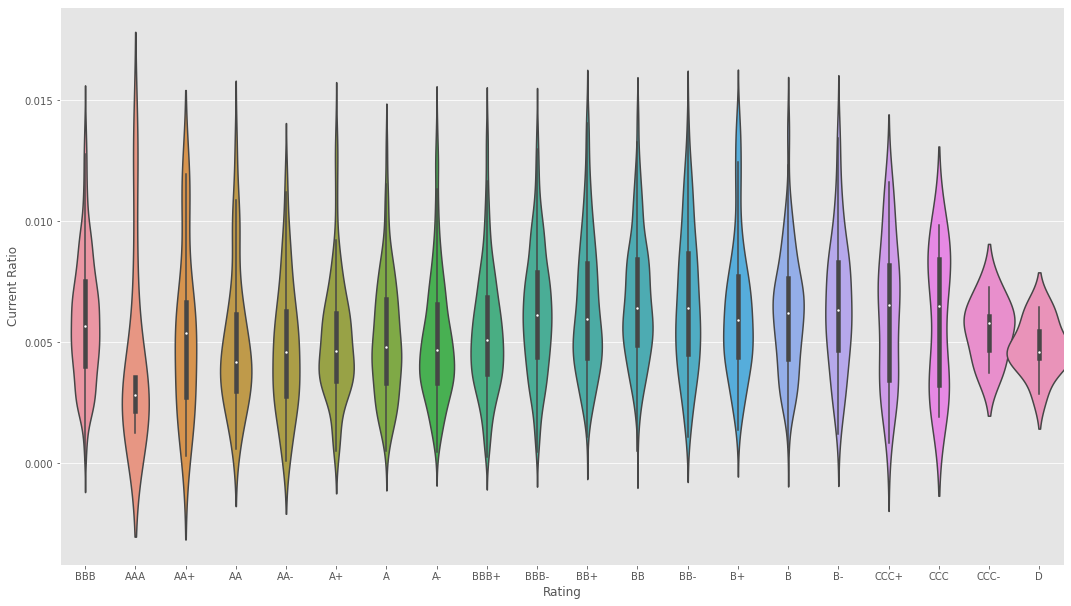

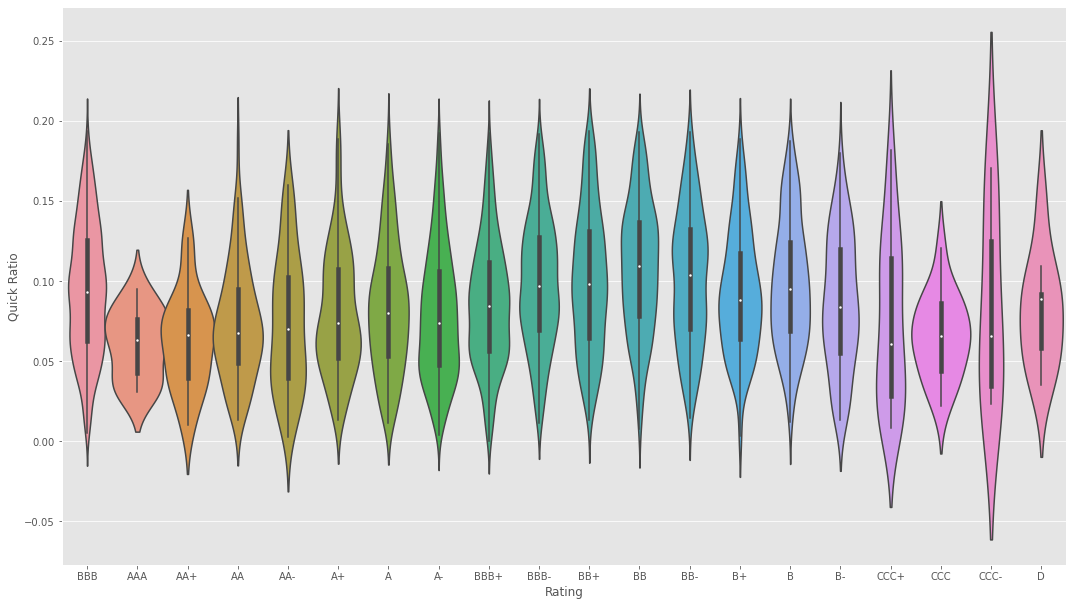

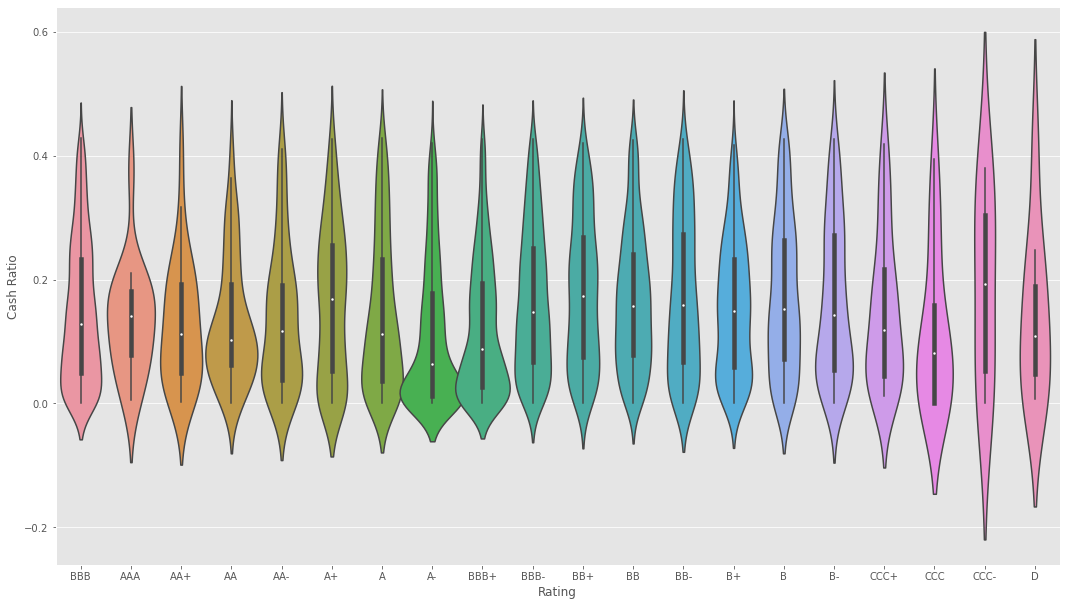

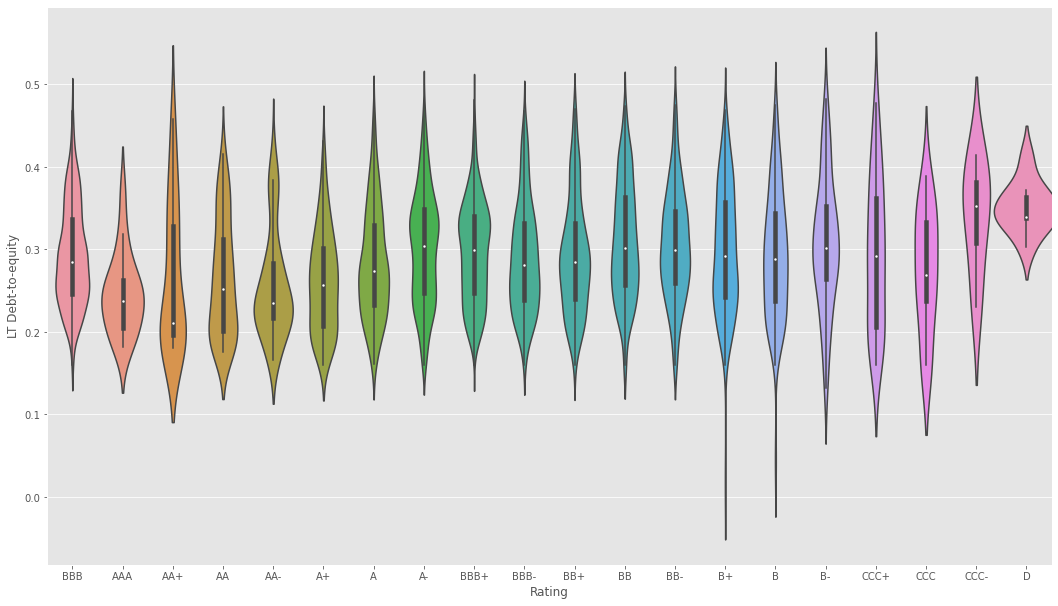

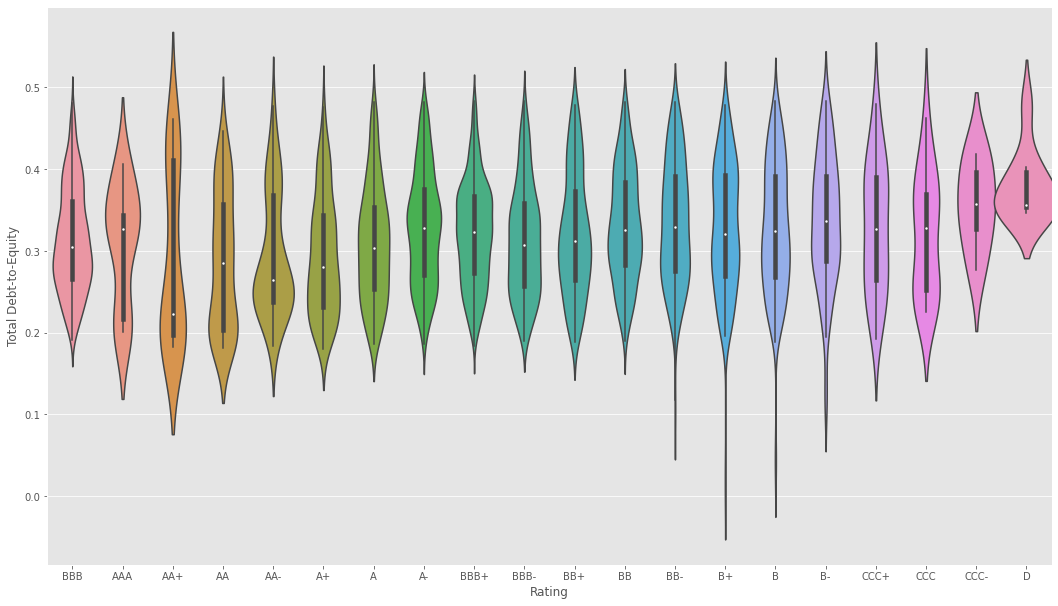

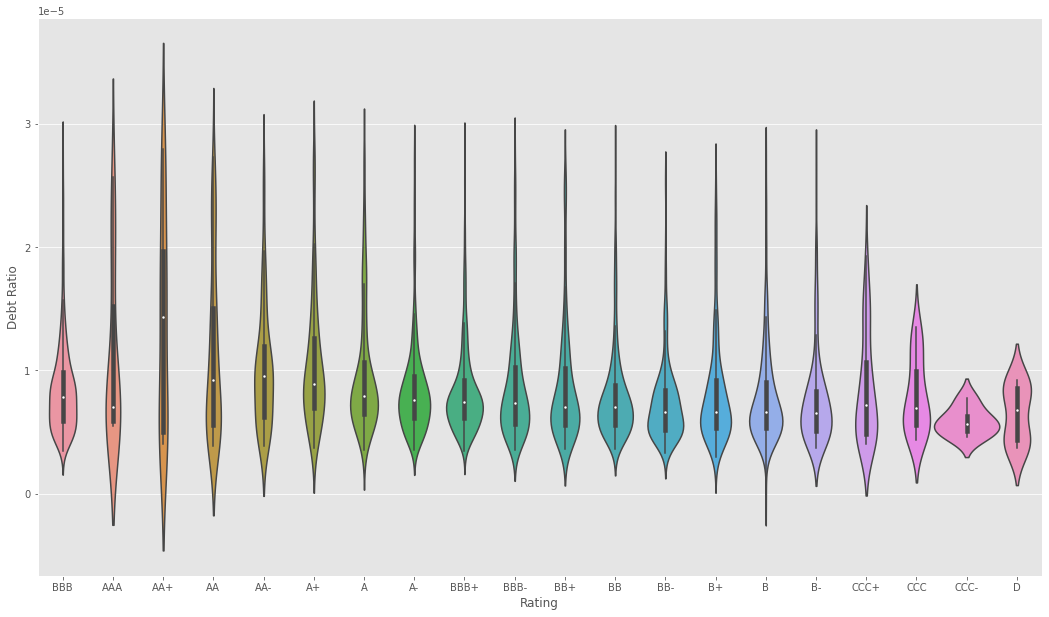

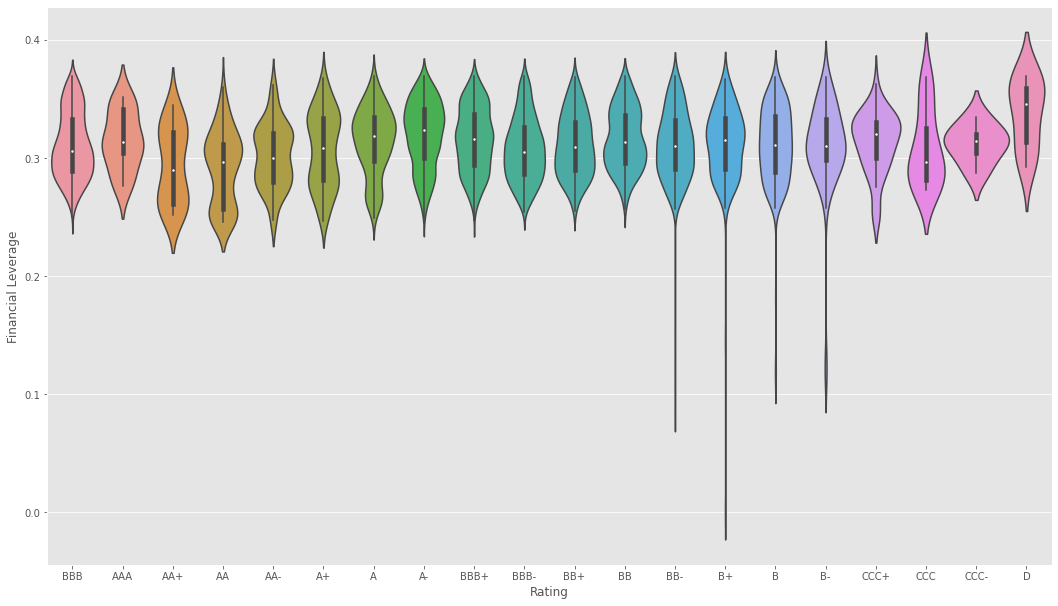

In [22]:
def violin_plot(df,x,y):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10.27)
    sns.violinplot(x=x, y=y, data=df, width = 1.3)

#Gráfico con la distribución de los datos por Rating
for y in df.columns[3:]:
    df_mod = clean_df(df,df.columns,0.1)
    if y in df_mod.columns:
#         print([len(set(df_mod[c])) for c in df_mod.columns])
        violin_plot(df_mod,'Rating', y)

Por ahora vamos a meter todas las variables pero parece que hay algunas que no van a funcionar, pero puede que al meter el sector mejoren. Por tanto ahora veamos que pasa por indústria.

{'Consumer Discretionary', 'Industrials', 'Utilities', 'Financials', 'Information Technology', '0', 'Health Care', 'Materials', 'Communication Services', 'Consumer Staples', 'Energy', 'Real Estate'}


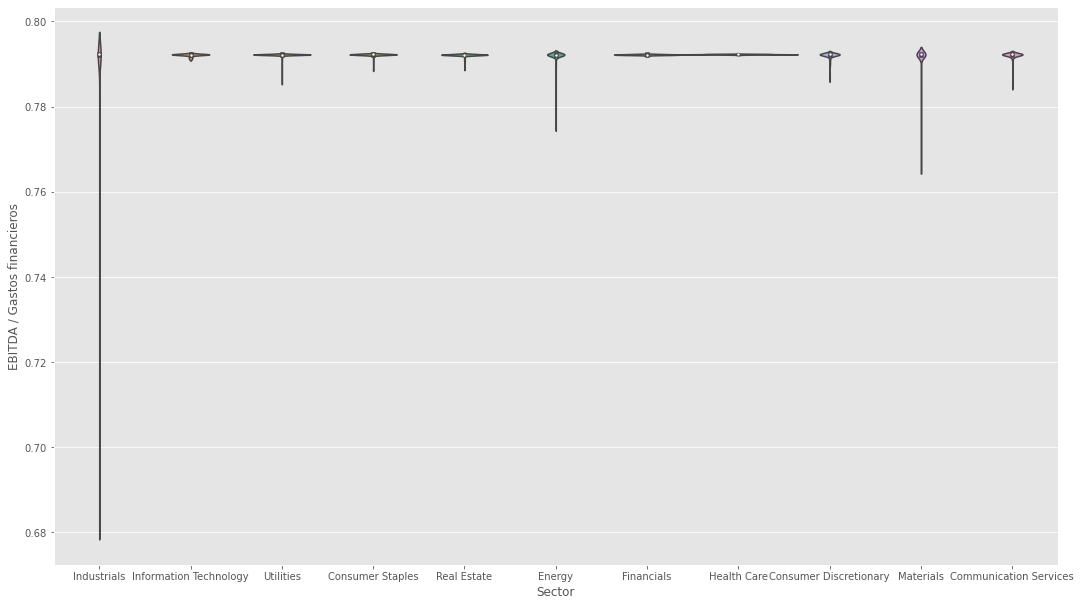

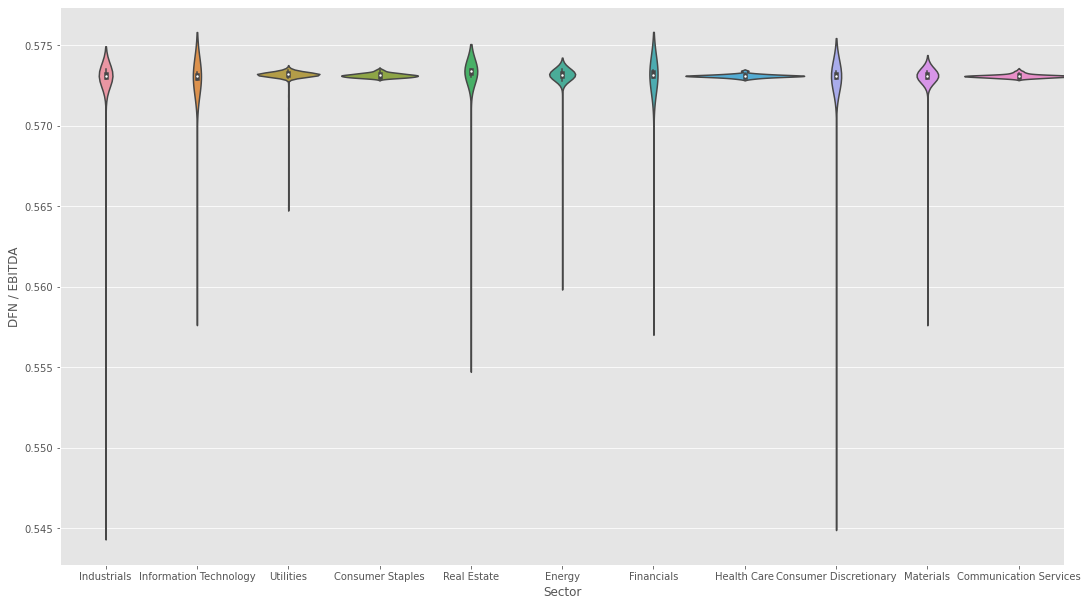

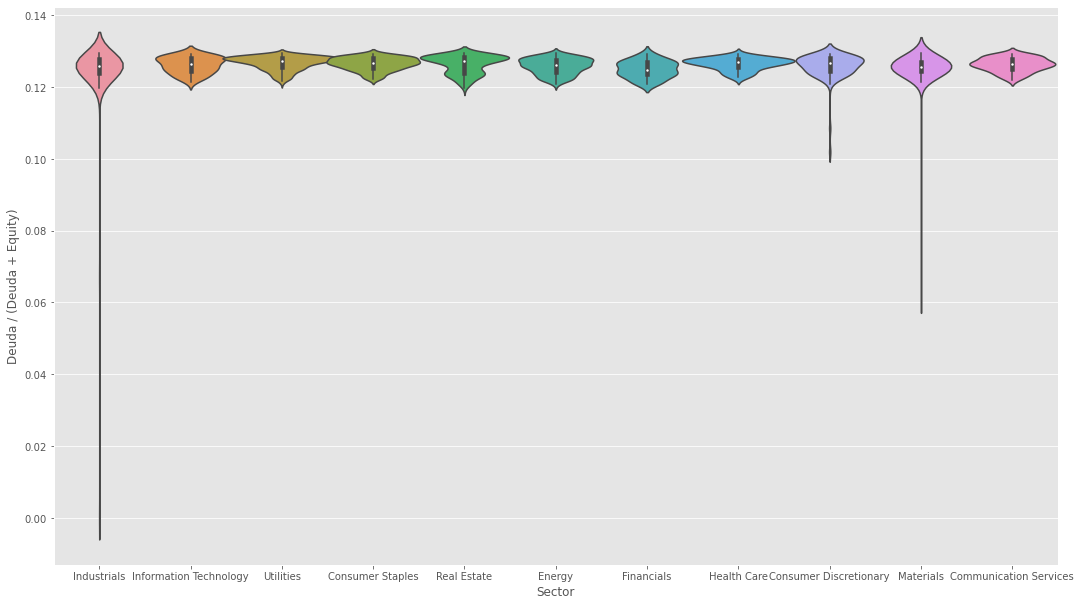

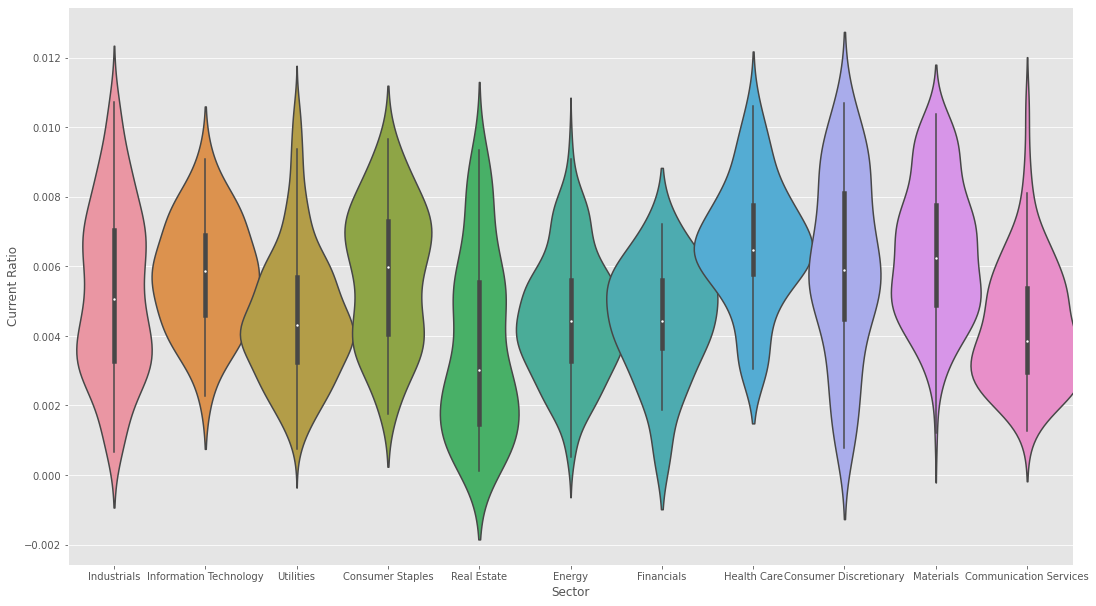

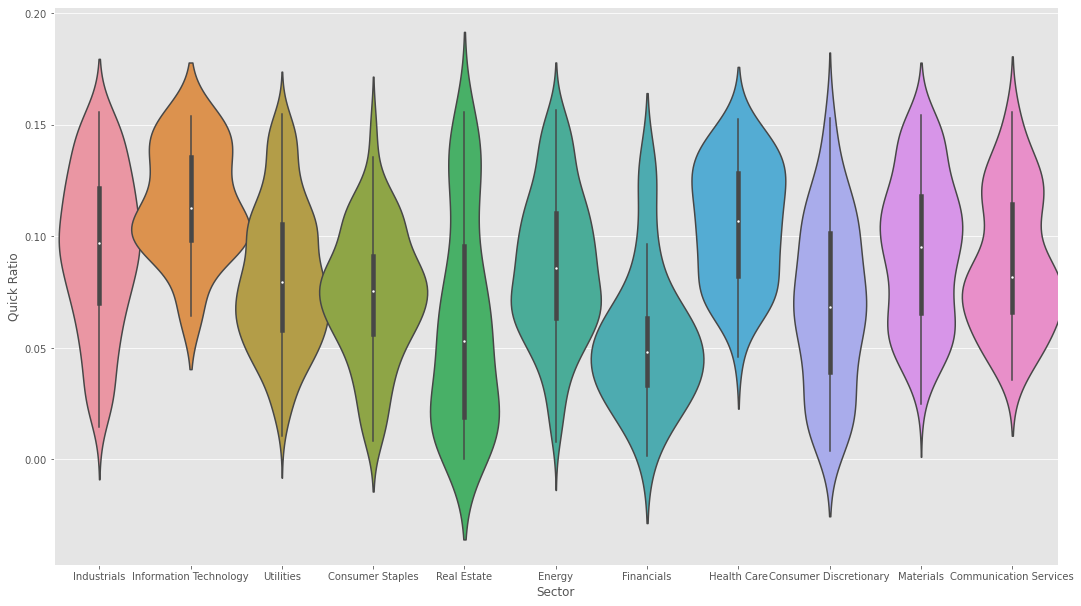

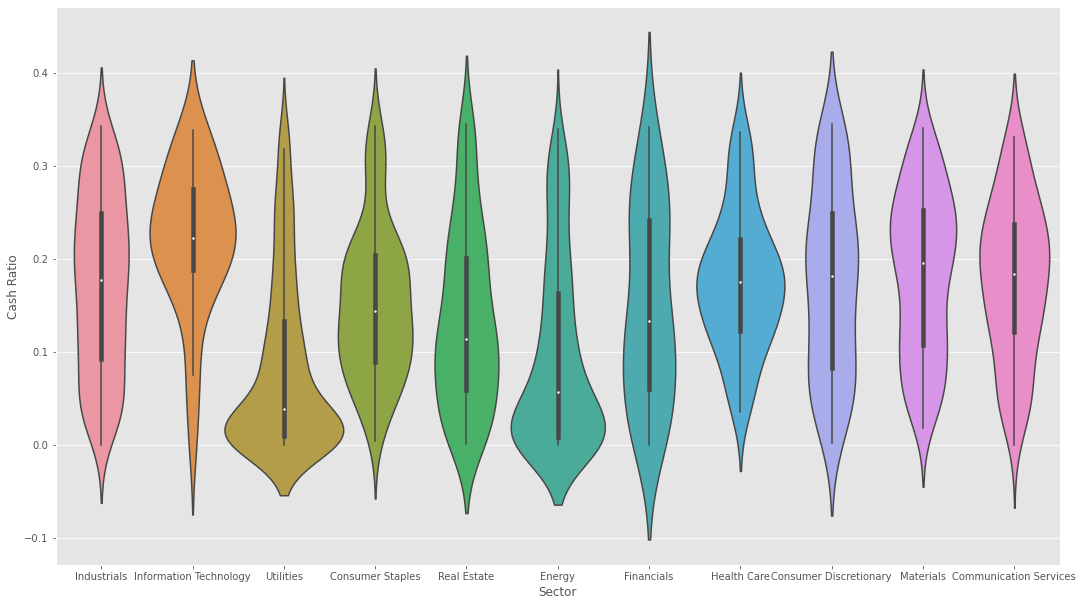

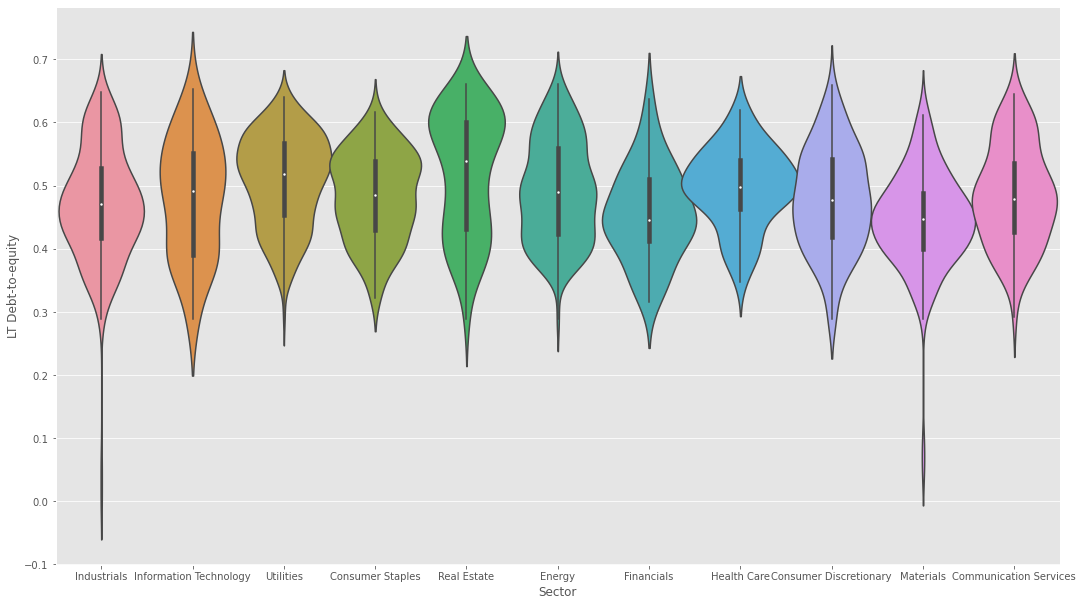

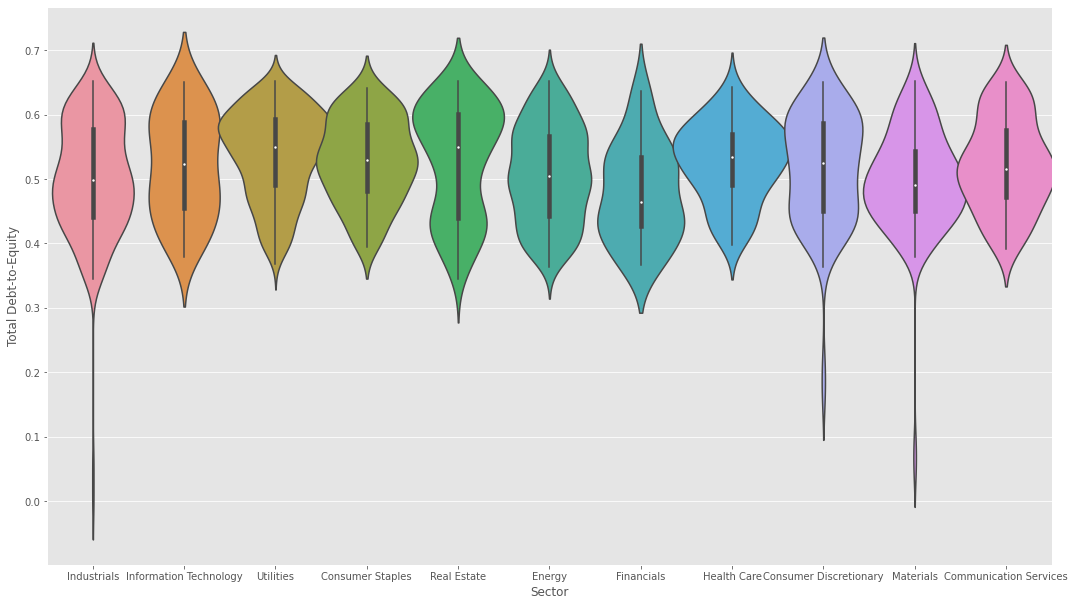

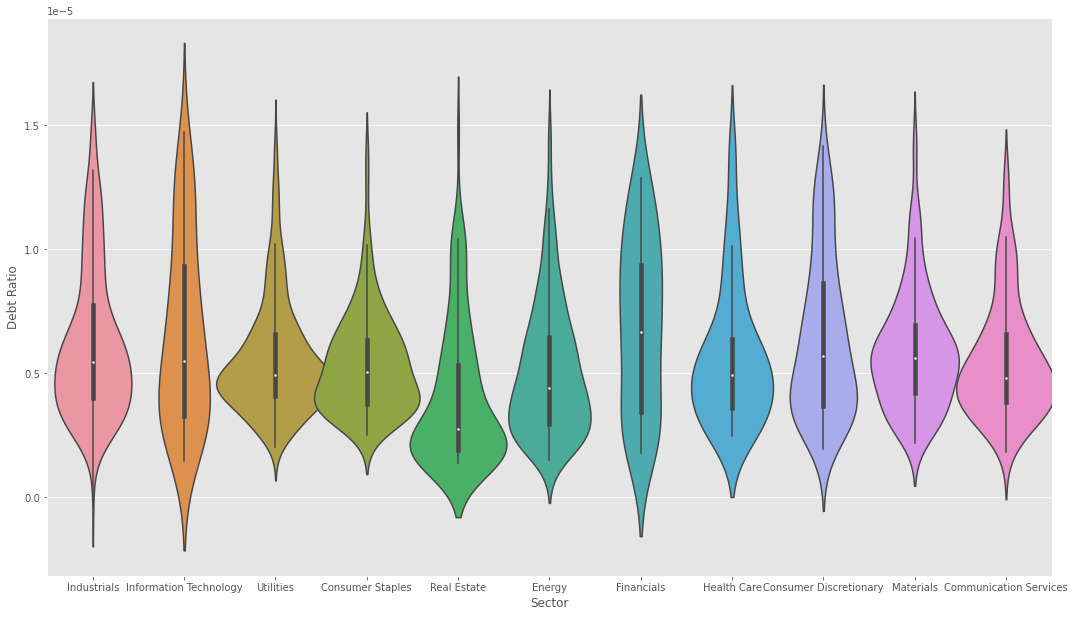

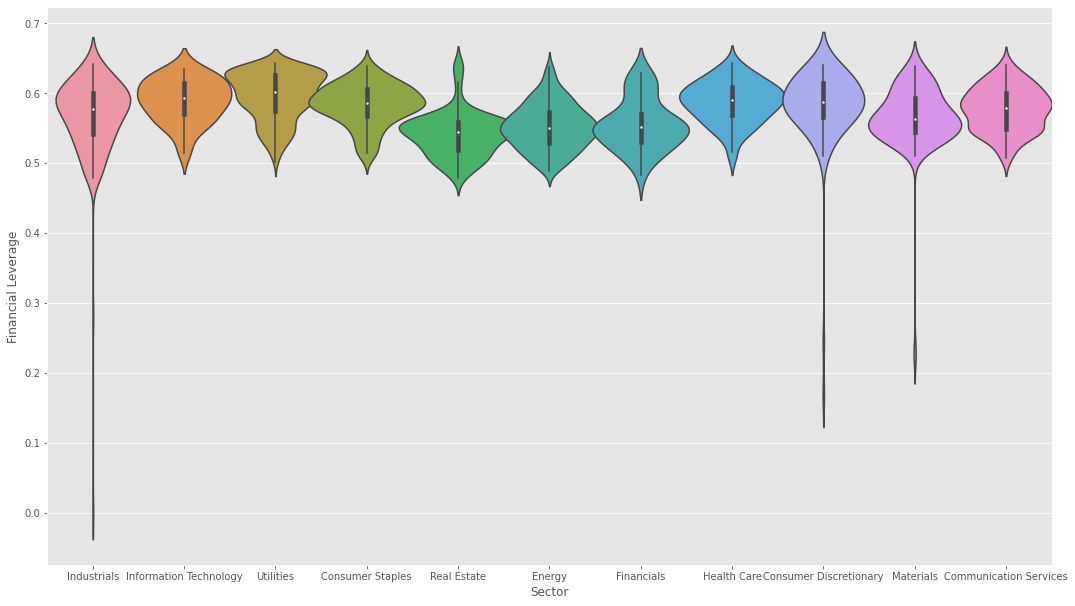

In [11]:
print(set(df['Sector']))
percentile = 0.2
for y in df.columns[3:]:
    df_mod = clean_df(df,df.columns,percentile)
    violin_plot(df_mod,'Sector', y)

Lo primero que haría es hacer un test estadístico para ver si las medias son estadisticamente diferentes entre ratings y sectores.

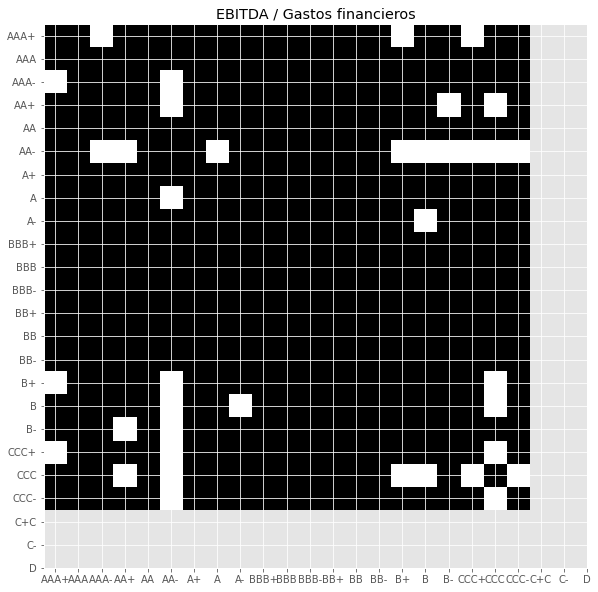

<Figure size 2160x720 with 0 Axes>

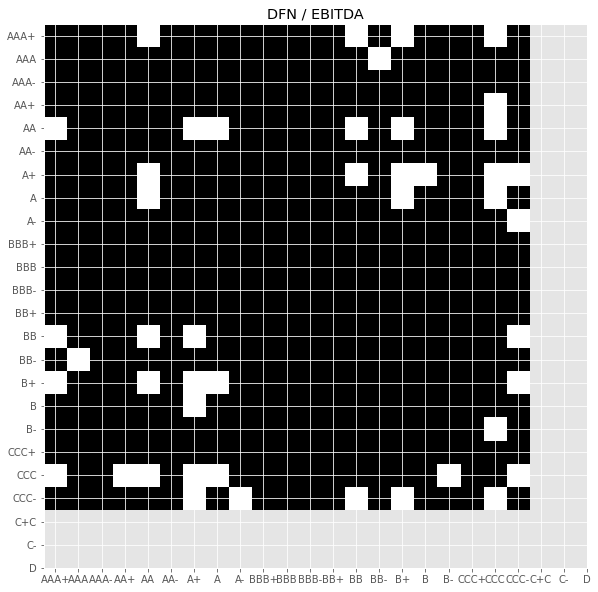

<Figure size 2160x720 with 0 Axes>

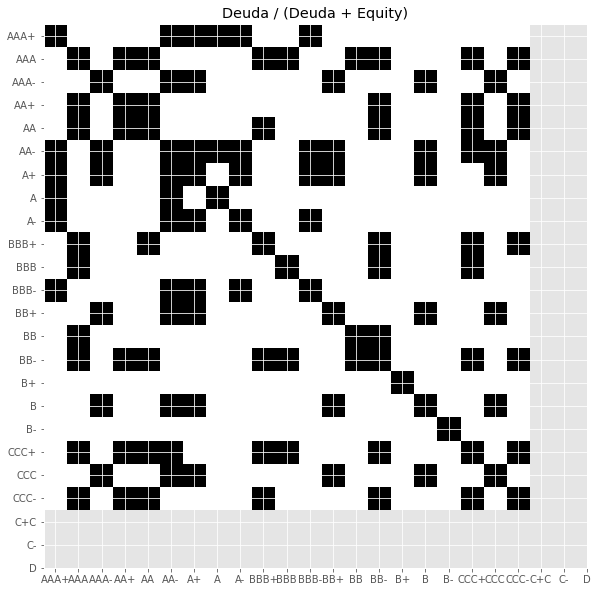

<Figure size 2160x720 with 0 Axes>

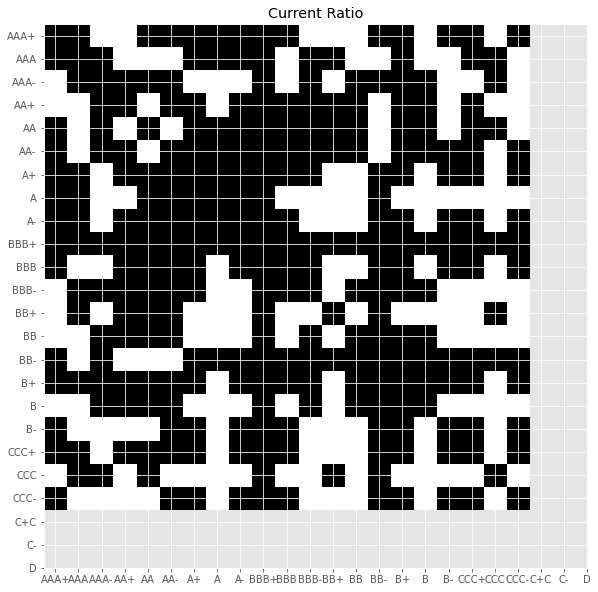

<Figure size 2160x720 with 0 Axes>

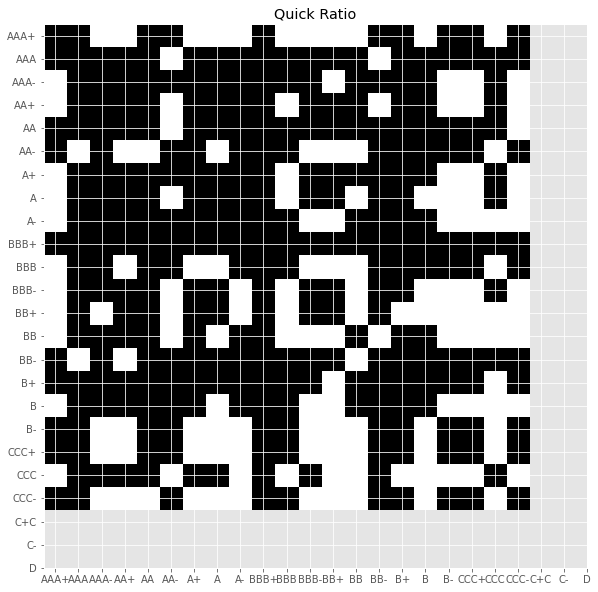

<Figure size 2160x720 with 0 Axes>

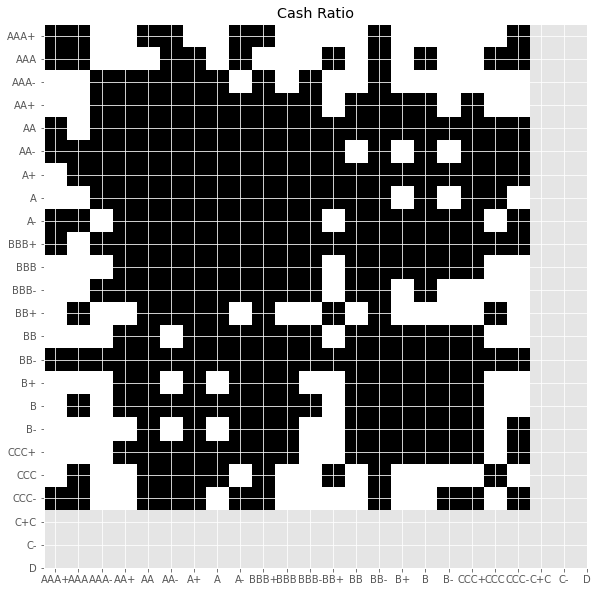

<Figure size 2160x720 with 0 Axes>

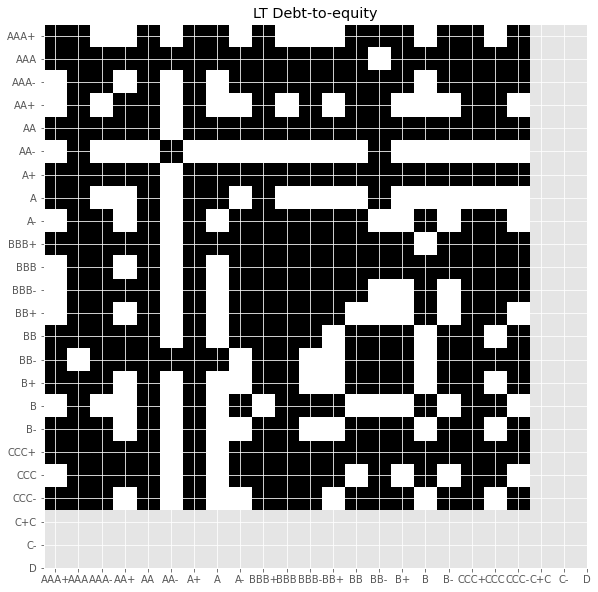

<Figure size 2160x720 with 0 Axes>

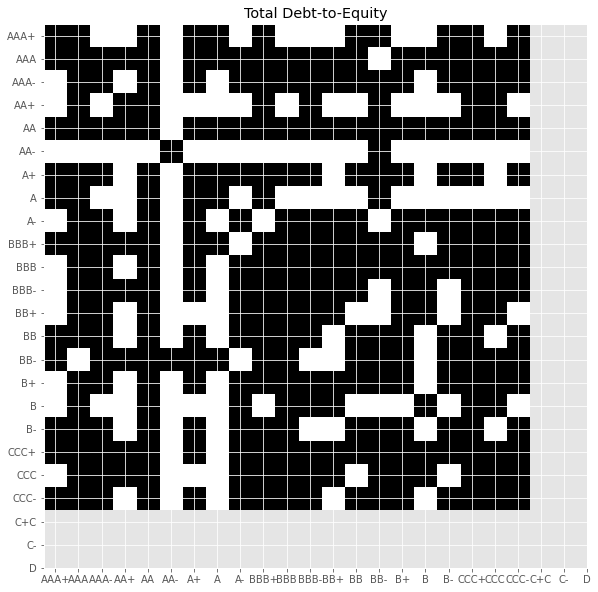

<Figure size 2160x720 with 0 Axes>

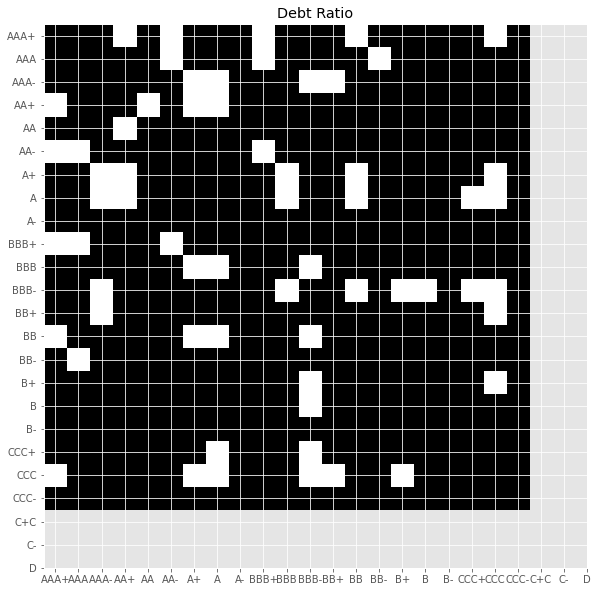

<Figure size 2160x720 with 0 Axes>

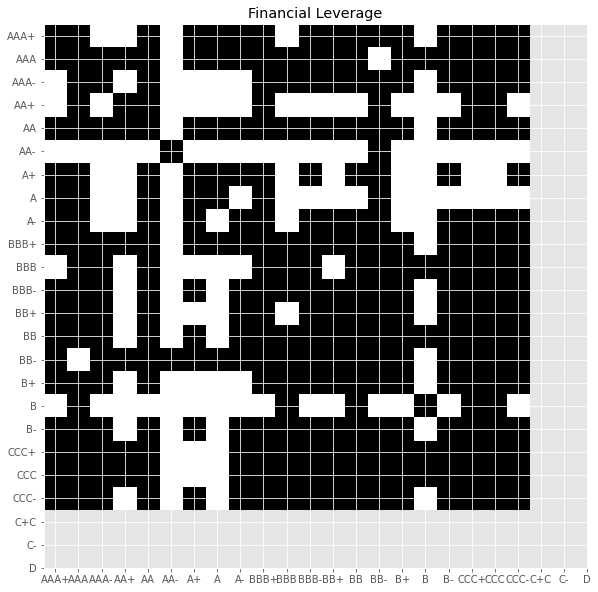

<Figure size 2160x720 with 0 Axes>

In [61]:
ratings = set(df['Rating'])
ratios = list(df.columns)[3:]
matrix = np.zeros((len(ratios),len(ratings),len(ratings)))

for i,ratio in enumerate(ratios):
    for j,rating1 in enumerate(ratings):
        for k,rating2 in enumerate(ratings):
            data1 = df[df['Rating'] == rating1][ratio]
            data2 = df[df['Rating'] == rating2][ratio]
            stat, p = ttest_ind(data1, data2)
#             print('Statistics=%.3f, p=%.3f' % (stat, p))
            alpha = 0.05
            if p > alpha:
                pass
#                 print('Same distributions (fail to reject H0): ', rating1,' vs ', rating2)
            else:
#                 print('O_O Different distributions (reject H0)', rating1,' vs ', rating2)
                matrix[i,j,k] = 1
    
size_plot = 10
for m,ratios in zip(matrix,ratios):
    fig = plt.figure(1, (size_plot * 1.6180, size_plot))

    plt.imshow(m,cmap = "gray",)
    plt.xticks([index for index, x in enumerate(All_rating_order)],
               All_rating_order)
    plt.yticks([index for index, x in enumerate(All_rating_order)],
               All_rating_order)
    plt.title(ratios)
    plt.figure(figsize=(30,10))
    plt.show()

In [62]:
ratings = set(df['Rating'])
ratios = list(df.columns)[3:]
matrix = np.array([])
p_values = []
alpha = 0.05
p_dict = {}

ratings_orde = []
#Ordenar los ratings
for rating in All_rating_order:
    if rating in ratings:
        ratings_orde.append(rating)
ratings = ratings_orde

#Construcción de un diccionario con los datos
for ratio in ratios:
    p_dict.update({ratio:{}})
    for rating1 in ratings:
        p_dict[ratio].update({rating1: {}})
        for rating2 in ratings:
            p_dict[ratio][rating1].update({rating2:999})
        
# print(p_dict)
#Rellenamos los datos
for ratio in ratios:
    for rating1 in ratings:
        for rating2 in ratings:
            data1 = df[df['Rating'] == rating1][ratio]
            data2 = df[df['Rating'] == rating2][ratio]
            stat, p = ttest_ind(data1, data2)
            p_dict[ratio][rating1][rating2]  = p
            p_values.append(p.round(4))
        matrix = np.concatenate((matrix,p_values))
        p_values = []
    matrix.reshape(len(ratings),len(ratings))
    matrix = np.array([])    

# print(p_dict)

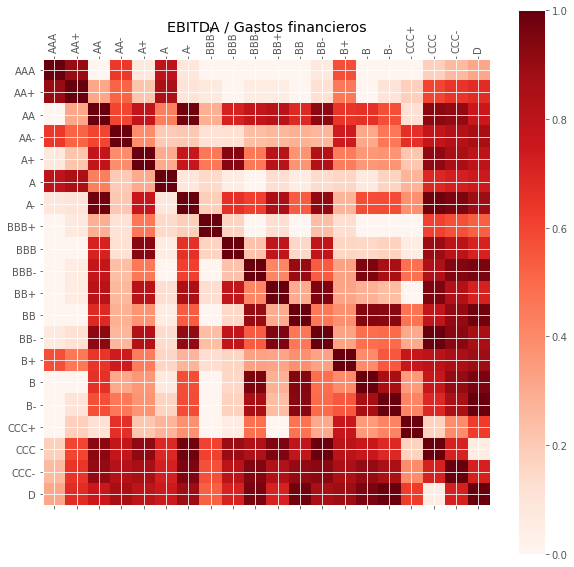

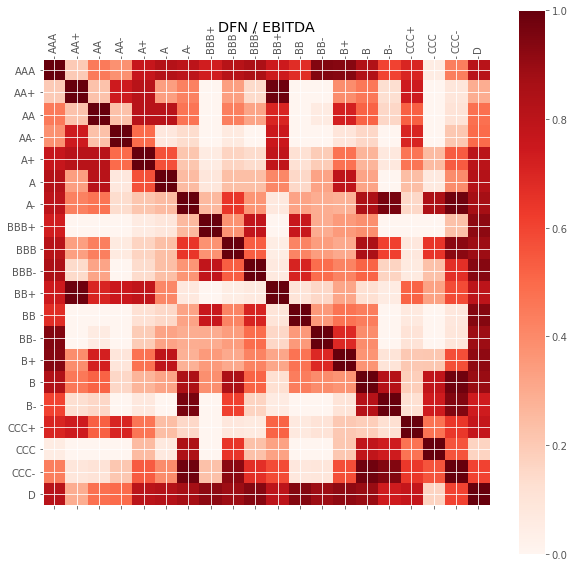

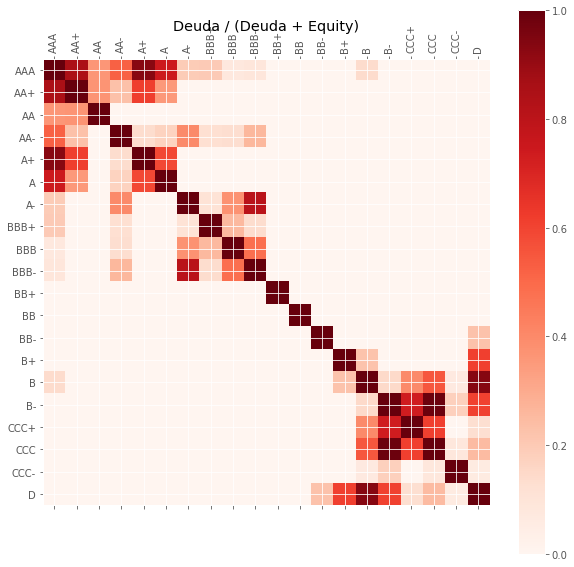

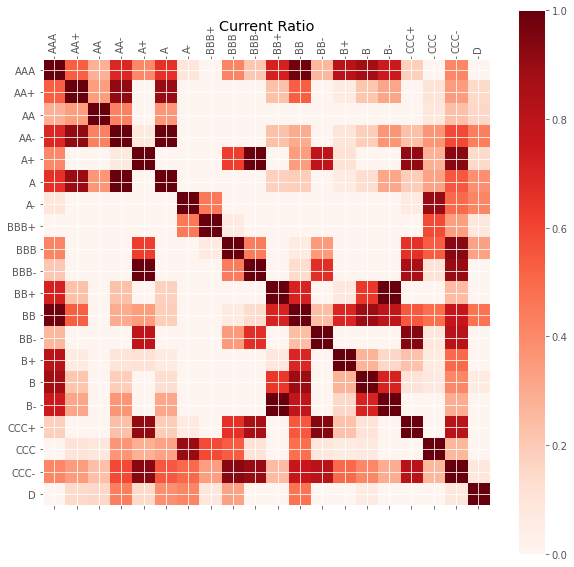

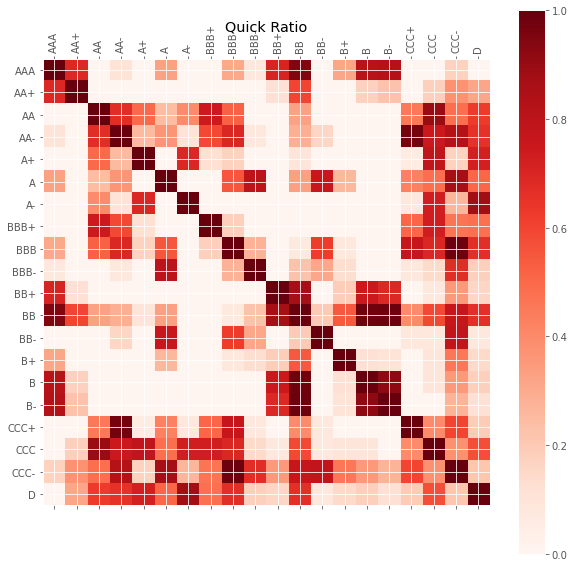

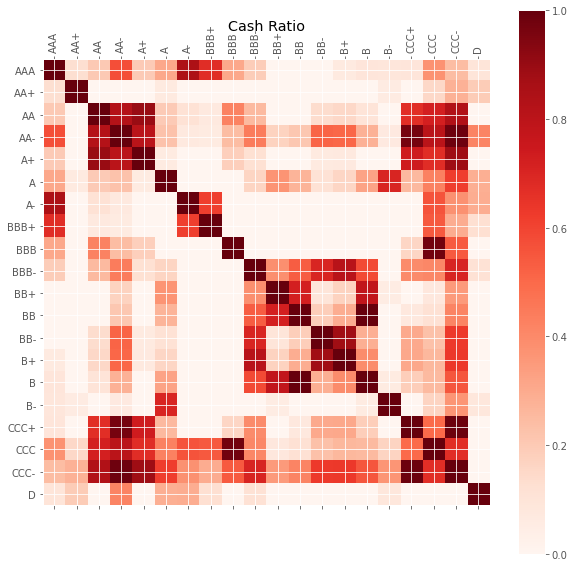

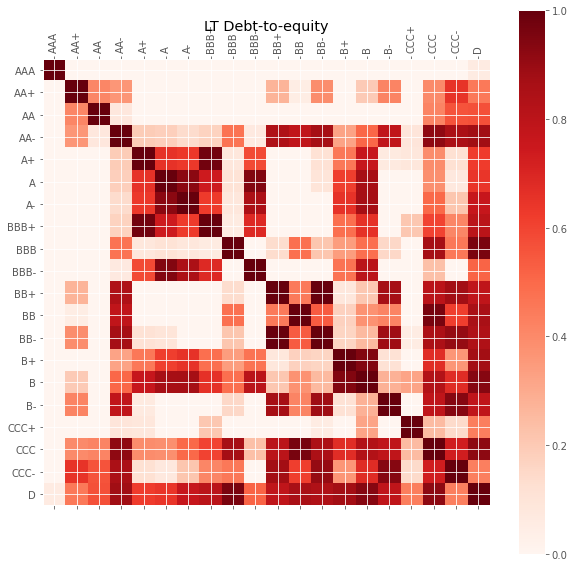

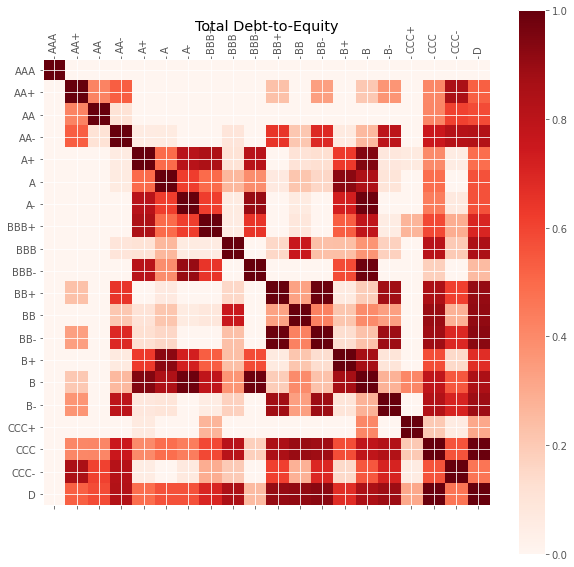

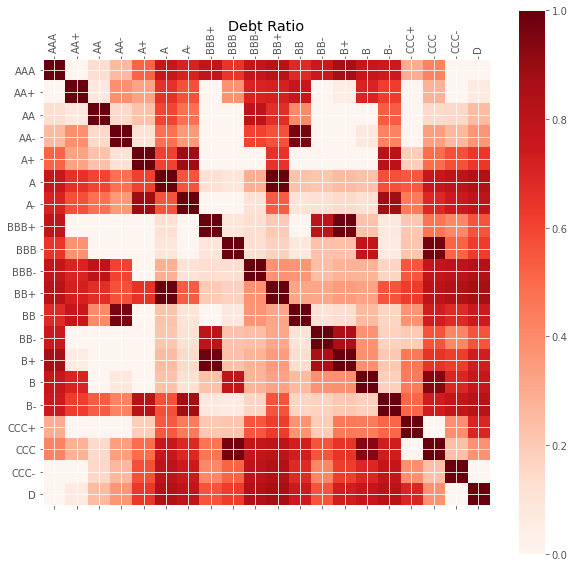

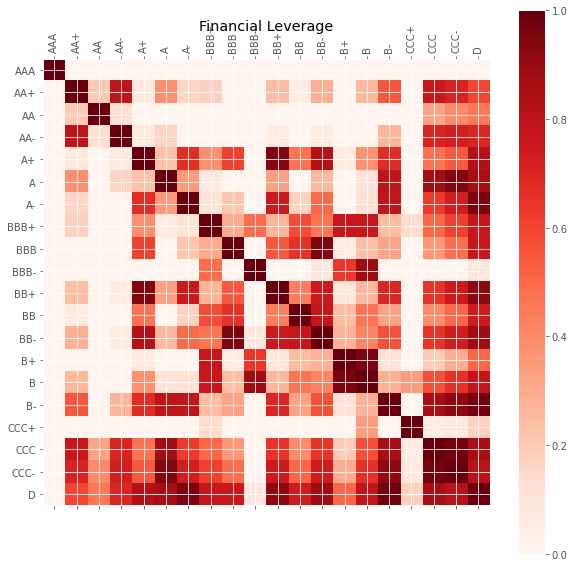

In [63]:
#Matriz de datos
corr = df.corr()

matrix = [] 
p_values = []

for ratio in ratios:
    for rating1 in ratings:
        for rating2 in ratings:
            if p_dict[ratio][rating1][rating2] > alpha:
                solution = p_dict[ratio][rating1][rating2]
            else:
                solution = 0
            p_values.append(solution)
        matrix.append(p_values)
#         print(len(p_values))
        p_values = []
#     print(rating1,matrix)
    size = 10
    fig, ax = plt.subplots(figsize=(size, size))
    car = ax.matshow(matrix, cmap = 'Reds')
    plt.xticks(range(len(ratings)), ratings,rotation = 90);
    plt.yticks(range(len(ratings)), ratings);
    fig.colorbar(car)
    plt.title(ratio)
    matrix = []



Ahora hacemos un estudio mas cuantitativo, para ver los sectores tines varibles significativamente diferentes.

**Fail to Reject H0:** La distribuciones muestrales son iguales

**Reject H0:** La distribuciones muestrales no son iguales

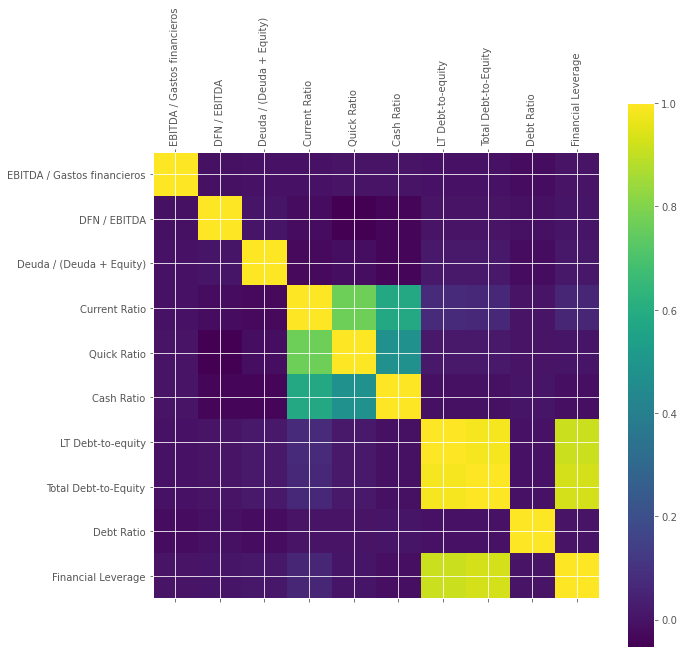

In [65]:
# buscar como ver la colinialidad entre ellas

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    
    fig, ax = plt.subplots(figsize=(size, size))
    car = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation = 90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    fig.colorbar(car)
    
plot_corr(df)

Intentamos reducir la dispersión de los datos.

In [76]:
df.columns

Index(['ID', 'Rating', 'Sector', 'EBITDA / Gastos financieros', 'DFN / EBITDA',
       'Deuda / (Deuda + Equity)', 'Current Ratio', 'Quick Ratio',
       'Cash Ratio', 'LT Debt-to-equity', 'Total Debt-to-Equity', 'Debt Ratio',
       'Financial Leverage'],
      dtype='object')

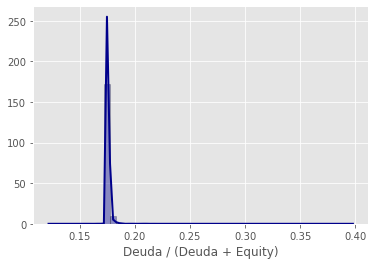

In [78]:
%matplotlib inline
c = df.columns[5]

sns.distplot(df[c], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

## Modelo

Arbol de decisión de nuestro algoritmo de Maching Learning
<img src="ml_map.png">

In [2]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
import pprint

Supongamos que ya tenemos los datos limpios y podemos empezar a crear el modelo.

In [65]:
df = pd.read_csv("Clean_Data_No_Normalizados.csv", index_col=0)
no_needed_data = ['Current Assets', 'Cash and equivalents', 'Receivables','Total Assets', 'Current Liabilities', 
                  'Long Term Debt', 'Total Debt','Total Equity', 'Gastos financieros netos', 'EBITDA']
df = df[[col for col in df.columns if not col in no_needed_data]]
df.head()

,Excel Company ID,ID,Company Name,Rating,Sector,EBITDA / Gastos financieros,DFN / EBITDA,Deuda / (Deuda + Equity),Current Ratio,Quick Ratio,Cash Ratio,LT Debt-to-equity,Total Debt-to-Equity,Debt Ratio,Financial Leverage
5398,IQ4149300,2018-IQ4149300,KOSE:A002380,BBB,Industrials,22.374497,3.487274,0.277097,0.941897,0.548960,0.145974,0.052844,0.383312,4.244308,1.626894
10000,IQ5522615,2018-IQ5522615,0,AAA,Industrials,7.317319,2.571325,0.526936,0.593457,0.562054,0.220716,1.066068,1.113879,2.472241,2.753777
10002,IQ32857171,2018-IQ32857171,0,AAA,Industrials,-0.193370,-71.942852,0.180990,2.021492,0.957016,0.655499,0.213464,0.220986,8.703797,1.923416
10008,IQ4112645,2018-IQ4112645,0,AAA,Industrials,2.871230,8.388013,0.911598,3.092016,3.011491,0.326559,9.669059,10.311905,1.376326,14.192542
10016,IQ5490337,2018-IQ5490337,0,AAA,Industrials,33.753628,-0.281920,-0.484957,5.332961,1.748943,1.017131,-0.289885,-0.326580,10.117879,-3.304293


Primero subtituir las variables Rating y Sector del modelo. Supogamos que simplemente se pueden subtituir con un diccionario.

In [66]:
All_rating_order = ['AAA+','AAA','AAA-','AA+','AA','AA-','A+','A','A-','BBB+','BBB','BBB-','BB+','BB','BB-','B+','B',
                   'B-','CCC+','CCC','CCC-','CC','C+''C','C-','D']

In [67]:
# El rating tiene que estar ordenado de forma que podríamos obtener por ejemplo un 1,5 si 1 = AAA+ y 2 = AAA nuestra
# compañia estaría entre uno y otro
replace_map = {'Sector':{industry:code for code,industry  in enumerate(set(df['Sector']))},
              'Rating':{rating:i for i,rating in enumerate(All_rating_order)}}

Ratings_order = {}
for rating,v in replace_map['Rating'].items():
    if rating in df['Rating'].values:
        Ratings_order.update({rating:v})
replace_map.update({'Rating_in_data':Ratings_order})

pp = pprint.PrettyPrinter(indent=3)
# pp.pprint(replace_map)

In [68]:
df_ready = df.replace(replace_map['Sector'])
df_ready = df_ready.replace(replace_map['Rating_in_data'])
print(len(df_ready))
df_ready.head()

16505


,Excel Company ID,ID,Company Name,Rating,Sector,EBITDA / Gastos financieros,DFN / EBITDA,Deuda / (Deuda + Equity),Current Ratio,Quick Ratio,Cash Ratio,LT Debt-to-equity,Total Debt-to-Equity,Debt Ratio,Financial Leverage
5398,IQ4149300,2018-IQ4149300,KOSE:A002380,10,11,22.374497,3.487274,0.277097,0.941897,0.548960,0.145974,0.052844,0.383312,4.244308,1.626894
10000,IQ5522615,2018-IQ5522615,1,1,11,7.317319,2.571325,0.526936,0.593457,0.562054,0.220716,1.066068,1.113879,2.472241,2.753777
10002,IQ32857171,2018-IQ32857171,1,1,11,-0.193370,-71.942852,0.180990,2.021492,0.957016,0.655499,0.213464,0.220986,8.703797,1.923416
10008,IQ4112645,2018-IQ4112645,1,1,11,2.871230,8.388013,0.911598,3.092016,3.011491,0.326559,9.669059,10.311905,1.376326,14.192542
10016,IQ5490337,2018-IQ5490337,1,1,11,33.753628,-0.281920,-0.484957,5.332961,1.748943,1.017131,-0.289885,-0.326580,10.117879,-3.304293


Nomalización de los datos. Tiene demasiada dispersion por tanto normalizamos las datos. Tenemos que guardar el maximo y minimo para poder deshacer y hacer esta transformación.

In [101]:
def escalado(X, metodo):
    if metodo == 'Normalizacion':
        escalado_1,escalado_2 = X.min(),X.max()
        X = (X-escalado_1)/(escalado_2- escalado_1)
    elif metodo == 'Estandiracicion':
        escalado_1,escalado_2 = df[columna].mean(),df[columna].std()
        X = (X - escalado_1) / escalado_2
    else:
        print('Metodo no valido')
        return None
    return X, escalado_1,escalado_2
    
    
def escalado_df(df,cols, metodo):
    escalados_1,escalados_2 = [],[]
    for columna in cols:
        
        df[columna],escalado_1,escalado_2 = escalado(np.array(df[columna]),metodo)
        escalados_1.append(escalado_1)
        escalados_2.append(escalado_2)
    
    return df,escalados_1,escalados_2
#         Aun así obtenemos muchos valores extremos. Para que sean mas compactos quitamos los percentiles 10.
#         df = df[df[columna] > df[columna].quantile(percentile)]
#         df = df[df[columna] < df[columna].quantile(1-percentile)]

In [78]:
df = pd.DataFrame(df_ready, copy=True)
metodo="Normalizacion"

df,escalados_1,escalados_2 = escalado_df(df,cols=df.columns[5:], metodo=metodo)
print(escalados_1,escalados_2)
df.head()

[-141461.39094159714, -5557.225300436032, -43.04073056852489, -0.3582949308755761, 0.0, -0.012686397490797157, -15484.047506539531, -20581.0632014176, 0.33060739903955383, -29501.090540882622] [15556.70464135021, 37204.44797157919, 204.9051056124271, 28923.495027624307, 28923.495027624307, 209.68420002492599, 2120.971067570042, 2133.9454064103243, 1752737.0, 2492.585877051139]


,Excel Company ID,ID,Company Name,Rating,Sector,EBITDA / Gastos financieros,DFN / EBITDA,Deuda / (Deuda + Equity),Current Ratio,Quick Ratio,Cash Ratio,LT Debt-to-equity,Total Debt-to-Equity,Debt Ratio,Financial Leverage
5398,IQ4149300,2018-IQ4149300,KOSE:A002380,10,11,0.901067,0.130040,0.174707,0.000045,0.000019,0.000757,0.879528,0.906073,2.232909e-06,0.922142
10000,IQ5522615,2018-IQ5522615,1,1,11,0.900971,0.130018,0.175714,0.000033,0.000019,0.001113,0.879585,0.906105,1.221880e-06,0.922177
10002,IQ32857171,2018-IQ32857171,1,1,11,0.900923,0.128276,0.174319,0.000082,0.000033,0.003186,0.879537,0.906065,4.777209e-06,0.922151
10008,IQ4112645,2018-IQ4112645,1,1,11,0.900942,0.130154,0.177266,0.000119,0.000104,0.001618,0.880074,0.906510,5.966204e-07,0.922535
10016,IQ5490337,2018-IQ5490337,1,1,11,0.901139,0.129951,0.171633,0.000197,0.000060,0.004911,0.879508,0.906041,5.583994e-06,0.921988


Vemos que al deshacer la transformacion volvemos con los datos iniciales

In [107]:
def desescalado(X,escalados_1,escalados_2,metodo):
    for i,(escalado_1,escalado_2) in enumerate(zip(escalados_1,escalados_2)):
        if metodo == 'Normalizacion':
            X[i] = X[i] * (escalado_2- escalado_1) + escalado_1
        elif metodo == 'Estandiracicion':
            X[i] = X[i] * escalado_2 + escalado_1
        else:
            print('Metodo no valido')
    return X

In [80]:
X = df.iloc[0]
desescalado(X[5:],escalados_1,escalados_2)

Excel Company ID                    IQ4149300
ID                             2018-IQ4149300
Company Name                     KOSE:A002380
Rating                                     10
Sector                                     11
EBITDA / Gastos financieros           22.3745
DFN / EBITDA                          3.48727
Deuda / (Deuda + Equity)             0.277097
Current Ratio                        0.941897
Quick Ratio                           0.54896
Cash Ratio                           0.145974
LT Debt-to-equity                   0.0528442
Total Debt-to-Equity                 0.383312
Debt Ratio                            4.24431
Financial Leverage                    1.62689
Name: 5398, dtype: object

Definición de las variables

In [81]:
y = []
X= []
for index, row in df.iterrows():
    y.append(float(row[3]))
    X.append(list(row[4:].values))
X = np.array(X)
y = np.array(y)

In [82]:
svm_clf = Pipeline([
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge", max_iter=500)),
])
svm_clf.fit(X, y)

c:\python\python38-32\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', max_iter=500))])

Medimos el error con los datos de testeo

In [83]:
X[1]

array([1.10000000e+01, 9.00970730e-01, 1.30018220e-01, 1.75714451e-01,
       3.29054265e-05, 1.94324351e-05, 1.11304648e-03, 8.79585188e-01,
       9.06104745e-01, 1.22187960e-06, 9.22177368e-01])

In [84]:
svm_clf.predict([X[1]]),y[1]

(array([17.]), 1.0)

## Guardar y cargar el modelo

Ahora guardamos los parámtros del modelo y lo guaradamos para poder usarlo rapidamente desde excel

Guardamos el modelo

In [85]:
model = svm_clf
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Cargamos el modelo para usarlo

In [86]:
loaded_model = pickle.load(open(filename, 'rb'))

In [87]:
output_model = loaded_model.predict([X[10]])
X[10],output_model,y[10]

(array([1.10000000e+01, 9.01106948e-01, 1.29961514e-01, 1.73846855e-01,
        2.98227691e-05, 1.24296606e-05, 3.73541934e-04, 8.79524633e-01,
        9.06058712e-01, 1.92278691e-05, 9.22163874e-01]),
 array([17.]),
 1.0)

In [88]:
invers_dict_rating = {v:k for k, v in replace_map['Rating'].items()}
invers_dict_rating[int(output_model)],invers_dict_rating[int(y[10])]

('B-', 'AAA')

Funcion que se llamara desde execel para usar el modelo

In [171]:
def estimate_rating(escalados,Sector,EBITDA_Gastos_financieros,DFN_EBITDA,Deuda_Deuda_Equity,Current_Ratio,Quick_Ratio,
                    Cash_Ratio,LT_Debt_to_equity,Total_Debt_to_Equity,Debt_Ratio,Financial_Leverage):
    
    Sectors = {'Communication_Services': 0,'Consumer_Discretionary': 9,'Consumer_Staples': 8,'Energy': 7,
              'Financials': 11,'Health_Care': 4,'Industrials': 2,
              'Information_Technology': 1,'Materials': 5,'Real_Estate': 10,'Utilities': 3}
    
    All_rating_order = ['AAA+','AAA','AAA-','AA+','AA','AA-','A+','A','A-','BBB+','BBB','BBB-','BB+','BB','BB-','B+','B',
                   'B-','CCC+','CCC','CCC-','CC','C+''C','C-','D']
    
    replace_map = {'Sector':{industry:code for industry,code  in Sectors.items()},
                   'Rating':{i:rating for i,rating in enumerate(All_rating_order)}}
    
    try:
        X = [replace_map['Sector'][Sector],EBITDA_Gastos_financieros,DFN_EBITDA,Deuda_Deuda_Equity,
             Current_Ratio,Quick_Ratio,Cash_Ratio,LT_Debt_to_equity,Total_Debt_to_Equity,Debt_Ratio,Financial_Leverage]
    except Exception as e:
        if type(e).__name__ == 'TypeError':
            print('Error en tipo de sector. Los secoteres disponibles son:',Sector.keys())
        else:
            print(e)
    #Faltaria leer los datos de escalados       
    if not escalados:
        X = escalado_nuevo(np.array(X[1:]),np.array(escalados_1),np.array(escalados_2),metodo)
        X = [replace_map['Sector'][Sector]] + list(X)
        
    filename = 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    output_model = loaded_model.predict([X])
    return replace_map['Rating'][int(output_model)]

In [169]:
estimate_rating(True, *['Industrials'] + X[1][1:].tolist())

'AA-'

### Inputs reales
En la realidad pasariamos los datos sin escalar

In [92]:
df_ready.iloc[0]

Excel Company ID                    IQ4149300
ID                             2018-IQ4149300
Company Name                     KOSE:A002380
Rating                                     10
Sector                                     11
EBITDA / Gastos financieros           22.3745
DFN / EBITDA                          3.48727
Deuda / (Deuda + Equity)             0.277097
Current Ratio                        0.941897
Quick Ratio                           0.54896
Cash Ratio                           0.145974
LT Debt-to-equity                   0.0528442
Total Debt-to-Equity                 0.383312
Debt Ratio                            4.24431
Financial Leverage                    1.62689
Name: 5398, dtype: object

In [175]:
x = np.array(df_ready.iloc[0][4:])
x = [float(v) for v in x[1:]]
x = ['Industrials'] + list(x)
x

['Industrials',
 22.374497105157584,
 3.4872741619921888,
 0.2770972296004152,
 0.9418969064113264,
 0.5489597419617178,
 0.14597441172397338,
 0.052844150531239434,
 0.3833118933093168,
 4.24430817790905,
 1.6268938034625344]

Primer se escalan y luego se pasan al modelo

In [161]:
def escalado_nuevo(X,escalados_1,escalados_2,metodo):
    if metodo == 'Normalizacion':
        X = (X-escalados_1)/(escalados_2- escalados_1)
    elif metodo == 'Estandiracicion':
        X = (X - escalados_1) / escalados_2
    else:
        print('Metodo no valido')
        return None
    return X

Datos desescalados a partir de las variables del modelo

In [178]:
estimate_rating(False,*x),invers_dict_rating[int(y[0])]

('AA-', 'BBB')

El último paso sería meter esta funcion en un arcico punto `.py` y guardar en otro archivo los dats para desescalar los datos